In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from dateutil.relativedelta import relativedelta
from scipy.special import expit
from scipy.optimize import fmin, minimize
import glob as glob
import matplotlib
matplotlib.style.use('ggplot')

# .py
%load_ext autoreload
%autoreload 2
import weather_alphas, weather_costs, model

/Users/JohnnyV/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


running model
getting cost from nweek ahead
getting bounded alphas ...
done getting alphas ...


In [2]:
def split_data(data):
    train_mask = (data.index < "2011")
    train = data[train_mask]
    test_mask = (data.index > "2011")
    test = data[test_mask]
    return train, test

### Retrieve Weather Data

In [3]:
all_weather = pd.read_csv("weather01-16.csv")

In [4]:
cm_weather = all_weather[all_weather.stn_name == "Chiang Mai"]
cm_weather.index = pd.DatetimeIndex(cm_weather.date)
mask = (cm_weather.index > "2003") & (cm_weather.index < "2016")
cm_weather = cm_weather[mask]

provinces_df = pd.read_csv("all-dengues.csv")
provinces_df.index = pd.DatetimeIndex(provinces_df.date)
provinces_df = provinces_df.drop(['date','date.1'],axis=1)
cm_dengues = provinces_df[provinces_df['จังหวัด'] == 'ChiangMai'].resample('W').size()
cm_dengues_df = pd.DataFrame(cm_dengues,columns=['cases'])

### Weather Data is only available til Aug of 2016 so use the data til end of 2015. Therefore, dengue data as well

In [5]:
cm_avg_weather = cm_weather[['avgrh','dday','maxtemp','meantemp','mintemp','rain']].resample('W').mean()
cm_dengues_weather = pd.concat([cm_avg_weather,cm_dengues_df[:-52]],axis=1)

cm_dengues_weather_split = split_data(cm_dengues_weather)
cm_dengues_train, cm_dengues_test = cm_dengues_weather_split[0], cm_dengues_weather_split[1]

In [87]:
def make_line(start_week,real,predictions,title,x_axis,y_axis,
              real_legend='Real',predict_legend='Prediction'):
    plt.figure(figsize=(12,6))
    plt.plot(range(len(real)),real,'-r',label=real_legend)
    plt.plot(range(start_week,len(predictions)+start_week),predictions,'-k',label=predict_legend,alpha=0.4)
    plt.axvline(start_week)
    plt.text((start_week*2)+10,300,'Prediction Start',horizontalalignment='center',verticalalignment='center')
    plt.xlabel(x_axis)
    plt.ylabel(y_axis)
    plt.legend()
    plt.title(title)
    
def plot_all_predictions(LAG, real, province, nweeks_to_predict, all_predictions):
    
    plt.figure(figsize=(13,6))
    plt.plot(range(len(real)),real,label='real')
    graph_title = "%s's Dengue Prediction"%province
    plt.title(graph_title)
    for i in range(len(all_predictions)):
        cur_week_guess = nweeks_to_predict[i]
        start_predict_week = LAG+(cur_week_guess-1)
        predicted_cases = all_predictions[i]
        x_weeks = range(start_predict_week,len(predicted_cases)+start_predict_week)
        line_label = "%d week guess"%cur_week_guess
        plt.plot(x_weeks,predicted_cases,label=line_label,alpha=0.8)
    
    seperate_train_test(cm_dengues_df.cases,cm_dengues_train)
    plt.axvline(LAG)
    plt.text((LAG*2)+10,300,'Prediction Start',horizontalalignment='center',verticalalignment='center')
    plt.xlabel("# week starting 2003")
    plt.ylabel("Dengue cases")
    plt.legend()
    plt.savefig("13-lags-14-weeks-weather-chiangmai.png")
    
def seperate_train_test(all_data,train_data):
    plt.axvspan(0, len(train_data), color='blue', alpha=0.1)
    plt.text((len(train_data)/2)-25,700,'Train Period',size=16)
    plt.axvline(len(train_data)+1,linewidth=0.5, color='green')
    plt.text(len(train_data)+20,700,'Test Period',size=16)
    plt.axvspan(len(train_data)+1, len(all_data), color='green', alpha=0.1)

In [64]:
%%time
cm_13 = weather_alphas.get_alphas(13,cm_dengues_train)

getting bounded alphas ...
done getting alphas ...
bnds 18 [(0.0, None), (0.0, None), (0.0, None), (0.0, None), (0.0, None), (0.0, None), (0.0, None), (0.0, None), (0.0, None), (0.0, None), (0.0, None), (0.0, None), (0.0, None), (0.0, None), (1.0, None), (None, None), (0.0, None), (None, None)]
arr 16 [  0.05   0.05   0.05   0.05   0.05   0.05   0.05   0.05   0.05   0.05
   0.05   0.05   0.05   0.05   0.75  20.  ]
CPU times: user 52min 25s, sys: 25.7 s, total: 52min 51s
Wall time: 55min 4s


In [67]:
cm_13

      fun: 24.181429327223356
 hess_inv: <18x18 LbfgsInvHessProduct with dtype=float64>
      jac: array([  1.51138480e-01,   0.00000000e+00,   5.82343063e-02,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
        -6.46593890e-04,   0.00000000e+00,   0.00000000e+00,
        -8.21387403e-02,  -6.81707135e-01,   4.94718009e+00,
         4.58936000e-02,   1.54360186e+02,   5.35370255e+00])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 5206
      nit: 187
   status: 0
  success: True
        x: array([  2.33881143e+01,   0.00000000e+00,   2.69111728e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         5.58184098e-03,   0.00000000e+00,   0.00000000e+00,
         5.79733337e-01,   5.25392589e+00,   1.00000000e+00,
         1.33598881e+01,   5.75061473e-04,  -8.52156788e-03])

In [85]:
def plot_prediction(LAG, real, ws, province, nweeks_to_predict=[1,2,4,8,16]):

    def n_week_ahead(cases_for_prediction, weeks_ahead, first_week_to_predict):

        cur_prediction = 0
        prev_cases = np.array(cases_for_prediction.cases)
        for i in range(weeks_ahead):
            week_to_predict = first_week_to_predict + i
            mean_temp = real.meantemp[first_week_to_predict]
            cur_prediction = model.guess(
                ws, 
                week_to_predict, 
                prev_cases,
                mean_temp)
            prev_cases = np.append(prev_cases[1:],cur_prediction) # deduct the first elm out
        return cur_prediction

    all_predictions = []
    for nweek in nweeks_to_predict: # 1,2,4,8,12
        predictions = []
        for start_week in range(len(real)-(LAG)):
            first_week_to_predict = start_week + LAG
            cases_for_prediction = real[start_week:first_week_to_predict]
            prediction = n_week_ahead(
                cases_for_prediction,
                nweek,
                first_week_to_predict)
            predictions.append(prediction)
        all_predictions.append(predictions)
#     return all_predictions

    ## plot all predictions
    plot_all_predictions(LAG, real.cases, province, nweeks_to_predict, all_predictions)

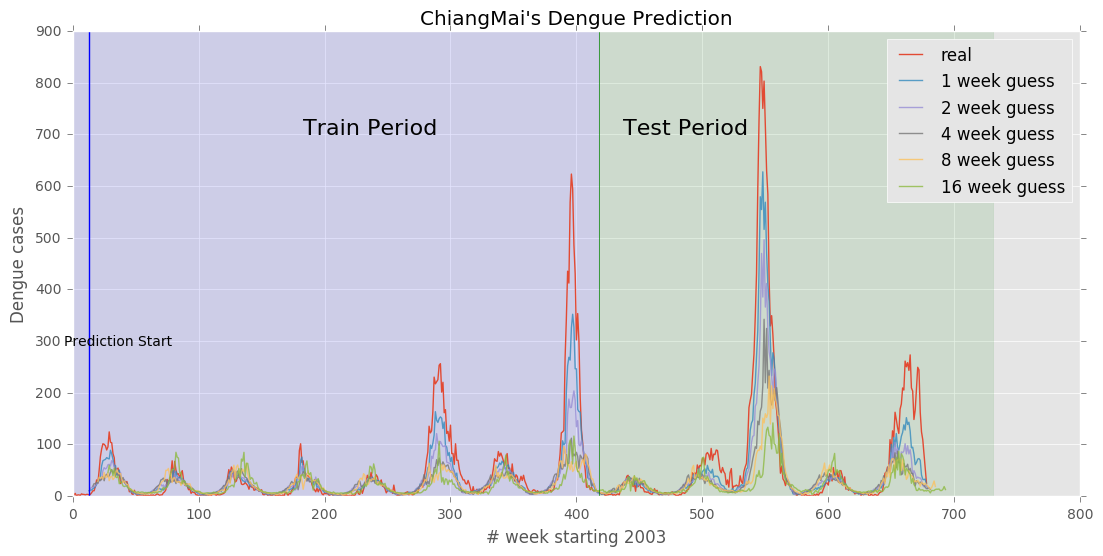

In [88]:
plot_prediction(13,cm_dengues_weather,cm_13.x,"ChiangMai")

In [71]:
cm_dengues_weather

,avgrh,dday,maxtemp,meantemp,mintemp,rain,cases
date,,,,,,,
2003-01-05,88.250000,3.500000,26.300000,23.500000,20.750000,3.050000,1
2003-01-12,81.000000,9.000000,27.942857,22.828571,17.757143,0.000000,2
2003-01-19,80.714286,16.000000,27.514286,21.457143,15.400000,0.000000,5
2003-01-26,75.857143,23.000000,27.728571,20.671429,13.700000,0.000000,0
2003-02-02,75.857143,21.142857,29.842857,22.628571,15.500000,0.000000,2
2003-02-09,74.857143,6.000000,28.842857,22.728571,16.685714,0.000000,2
2003-02-16,70.857143,13.000000,32.457143,24.957143,17.514286,0.000000,1
2003-02-23,62.857143,20.000000,32.885714,24.200000,15.585714,0.000000,4
2003-03-02,57.857143,19.000000,34.200000,24.457143,14.742857,0.000000,3


In [7]:
def nweek_ahead_cost(ws, week_forward ,start_week, end_week, data, cases_for_pred):
    
#     print end_week
    ret = 0
    for aweek in range(week_forward): # 14 loops; when you want to predict 14 weeks ahead
        week_to_predict = aweek+end_week
        real_case = data.cases[aweek+end_week] +1 # avoid getting zeros
        mean_temp = data.meantemp[week_to_predict]
        
        print "real",real_case - 1
        print "mean_temp",mean_temp
        print 'wtp',week_to_predict
#         print cases_for_pred
        
        predicted_case = model.guess(
          ws, 
          week_to_predict, 
          cases_for_pred,
          mean_temp)
        
        cases_for_pred = np.append(cases_for_pred[1:],predicted_case)
        sigma_sq = real_case + 1
        ret += ((real_case - predicted_case)**2)/float(sigma_sq)
    return ret
    
    
data = cm_dengues_train[:42] #range(1,100)
start_week,end_week = 0,26
week_forward = 16

all_penalties = []
for real_week in range(len(data)-(week_forward+end_week-1)):
    cases_for_pred = data.cases[start_week:end_week]
#     mean_temp = data.meantemp[]
#     print len(cases_for_pred)
#     print 'fw',future_week
#     print "meantemp", data.meantemp[real_week]
    cur_penalty = nweek_ahead_cost(
        [1.]*31, 
        week_forward, 
        start_week, 
        end_week, 
        data, 
        cases_for_pred)
    
    all_penalties.append(cur_penalty)
        
    start_week+=1
    end_week+=1

# all_penalties

real 97
mean_temp 27.0142857143
wtp 26
real 89
mean_temp 27.8571428571
wtp 27
real 95
mean_temp 28.4285714286
wtp 28
real 124
mean_temp 27.7285714286
wtp 29
real 104
mean_temp 27.6285714286
wtp 30
real 103
mean_temp 28.3142857143
wtp 31
real 82
mean_temp 27.1857142857
wtp 32
real 74
mean_temp 26.4571428571
wtp 33
real 39
mean_temp 27.2714285714
wtp 34
real 51
mean_temp 27.0285714286
wtp 35
real 54
mean_temp 26.9857142857
wtp 36
real 45
mean_temp 28.5571428571
wtp 37
real 24
mean_temp 27.0857142857
wtp 38
real 27
mean_temp 27.6714285714
wtp 39
real 29
mean_temp 28.2857142857
wtp 40
real 27
mean_temp 27.5714285714
wtp 41


In [70]:
cm_dengues_train[['cases','meantemp']][27:42]

,cases,meantemp
date,,
2003-07-13,89,27.857143
2003-07-20,95,28.428571
2003-07-27,124,27.728571
2003-08-03,104,27.628571
2003-08-10,103,28.314286
2003-08-17,82,27.185714
2003-08-24,74,26.457143
2003-08-31,39,27.271429
2003-09-07,51,27.028571
